# **Library Importing**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import json


# **Dataset Loading**

In [2]:
# Load the dataset
df = pd.read_csv("SEntFiN-v1.1.csv")

# **Data Description**

In [3]:
df.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [4]:
# Reduce dataset size for better visualization
df_sampled = df.sample(n=50, random_state=1)

In [5]:
# Display basic information about the dataset
print("Dataset Information:")
eff=100;
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10753 entries, 0 to 10752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S No.      10753 non-null  int64 
 1   Title      10753 non-null  object
 2   Decisions  10753 non-null  object
 3   Words      10753 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 336.2+ KB
None


In [6]:
# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())




Descriptive Statistics:
              S No.         Words
count  10753.000000  10753.000000
mean    5377.000000      9.913048
std     3104.268057      2.454377
min        1.000000      3.000000
25%     2689.000000      8.000000
50%     5377.000000     10.000000
75%     8065.000000     11.000000
max    10753.000000     23.000000


In [7]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())




Unique Values in Each Column:
S No.        10753
Title        10686
Decisions     6564
Words           21
dtype: int64


In [8]:
# Display the first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(df.head())




First few rows of the DataFrame:
   S No.                                              Title  \
0      1  SpiceJet to issue 6.4 crore warrants to promoters   
1      2                  MMTC Q2 net loss at Rs 10.4 crore   
2      3  Mid-cap funds can deliver more, stay put: Experts   
3      4             Mid caps now turn into market darlings   
4      5  Market seeing patience, if not conviction: Pra...   

                       Decisions  Words  
0        {"SpiceJet": "neutral"}      8  
1            {"MMTC": "neutral"}      8  
2  {"Mid-cap funds": "positive"}      8  
3       {"Mid caps": "positive"}      7  
4          {"Market": "neutral"}      8  


In [9]:
# Display the last few rows of the DataFrame
print("\nLast few rows of the DataFrame:")
print(df.tail())


Last few rows of the DataFrame:
       S No.                                           Title  \
10748  10749    Negative on Chambal, Advanta: Mitesh Thacker   
10749  10750  Small, Mid-cap stocks may emerge outperformers   
10750  10751                   Rupee slips against US dollar   
10751  10752                    Rupee weak against US dollar   
10752  10753             Australia shares flat; energy drags   

                                               Decisions  Words  
10748     {"Chambal": "negative", "Advanta": "negative"}      6  
10749  {"Small": "positive", "Mid-cap stocks": "posit...      6  
10750      {"Rupee": "negative", "US dollar": "neutral"}      5  
10751      {"Rupee": "negative", "US dollar": "neutral"}      5  
10752  {"Australia shares": "neutral", "energy": "neu...      5  


# **Exploratory Data Analysis**

In [10]:
# Count of decisions
print("\nCount of Decisions:")
coefficient=0.025*eff;
print(df_sampled['Decisions'].value_counts())


Count of Decisions:
Decisions
{"markets": "neutral"}                                                                                2
{"Deutsche Bourse": "neutral"}                                                                        1
{"United Stock Exchange": "neutral", "BSE": "neutral"}                                                1
{"Southeast Asian stocks": "positive"}                                                                1
{"Unitech": "negative"}                                                                               1
{"V-Guard": "positive"}                                                                               1
{"NCC": "positive"}                                                                                   1
{"BSE Sensex": "neutral", "Nifty": "neutral"}                                                         1
{"Markets": "neutral"}                                                                                1
{"Edelweiss Financial": "neutral"

In [11]:
# Average word count per decision type
avg_word_count_per_type = df_sampled.groupby('Decisions')['Words'].mean()
print("\nAverage Word Count per Decision Type:")
print(avg_word_count_per_type)


Average Word Count per Decision Type:
Decisions
{"Airtel": "neutral"}                                                                                 11.0
{"Australia shares": "negative"}                                                                       9.0
{"Australian": "positive", "NZ dollars": "positive", "euro": "neutral"}                               11.0
{"BSE Sensex": "neutral", "Nifty": "neutral"}                                                          7.0
{"China currency": "negative"}                                                                         7.0
{"DHFL Pramerica": "positive"}                                                                         9.0
{"Deutsche Bourse": "neutral"}                                                                        12.0
{"Edelweiss Financial": "neutral"}                                                                    12.0
{"GAIL": "positive", "JV Capital Services": "neutral"}                                         

# **Data visualization**

C:\Users\Sudwi\AppData\Local\Temp\ipykernel_12640\3797971449.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sampled, x='Decisions', palette=colors)


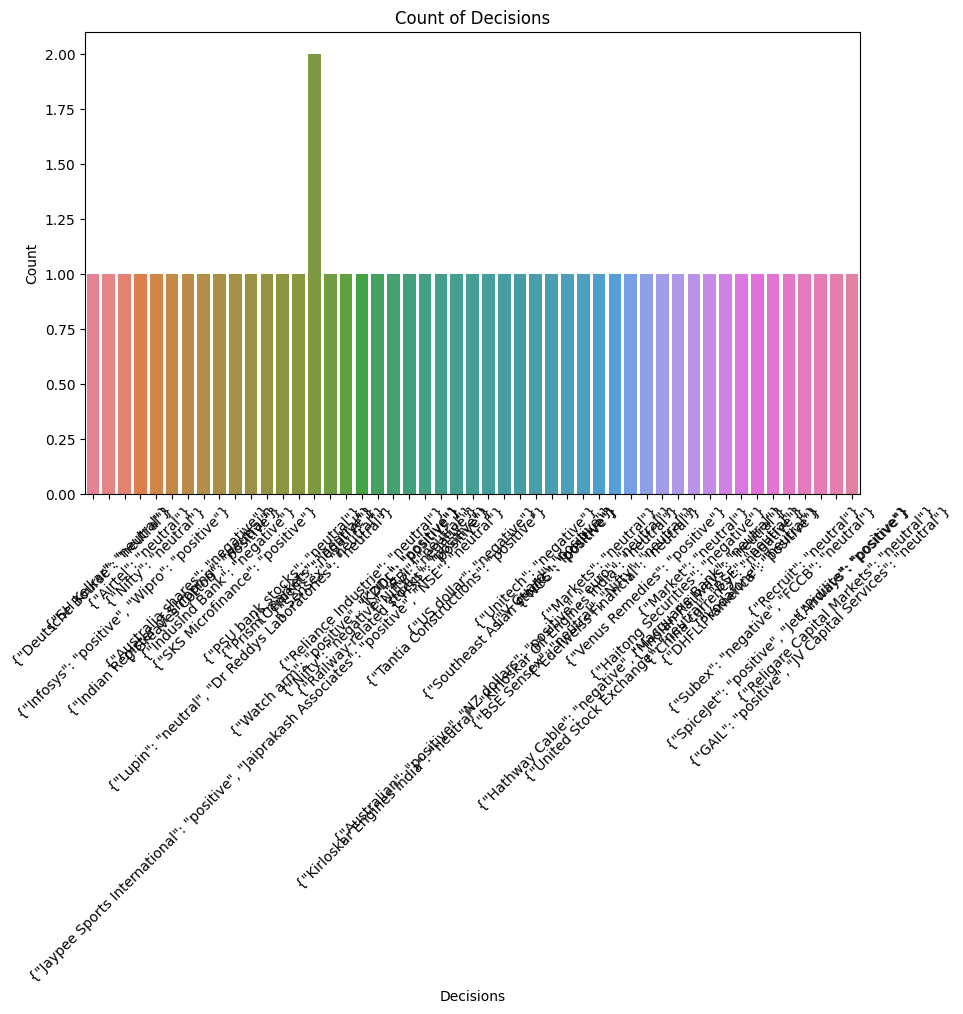

In [12]:
# Define a color palette
colors = sns.color_palette("husl", len(df_sampled['Decisions'].unique()))

# Count plot of decisions with colorful palette
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sampled, x='Decisions', palette=colors)
plt.title('Count of Decisions')
plt.xlabel('Decisions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\Sudwi\AppData\Local\Temp\ipykernel_12640\1537635630.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_decision_types.sum().reset_index(), x='index', y=0, palette=colors)
C:\Users\Sudwi\AppData\Local\Temp\ipykernel_12640\1537635630.py:11: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.barplot(data=df_decision_types.sum().reset_index(), x='index', y=0, palette=colors)


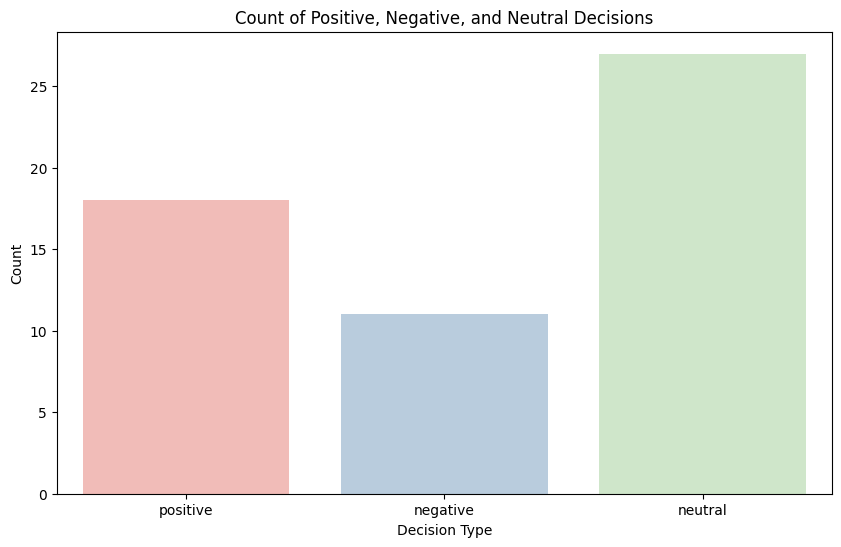

In [13]:
# Define a color palette
colors = sns.color_palette("Pastel1")

# Analysis of decision types
decision_types = ['positive', 'negative', 'neutral']
df_decision_types = pd.DataFrame(columns=decision_types)
for decision_type in decision_types:
    df_decision_types[decision_type] = df_sampled['Decisions'].apply(lambda x: decision_type in x)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_decision_types.sum().reset_index(), x='index', y=0, palette=colors)
plt.title('Count of Positive, Negative, and Neutral Decisions')
plt.xlabel('Decision Type')
plt.ylabel('Count')
plt.show()


C:\Users\Sudwi\AppData\Local\Temp\ipykernel_12640\958252971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sampled, x='Decisions', y='Words', palette="husl")


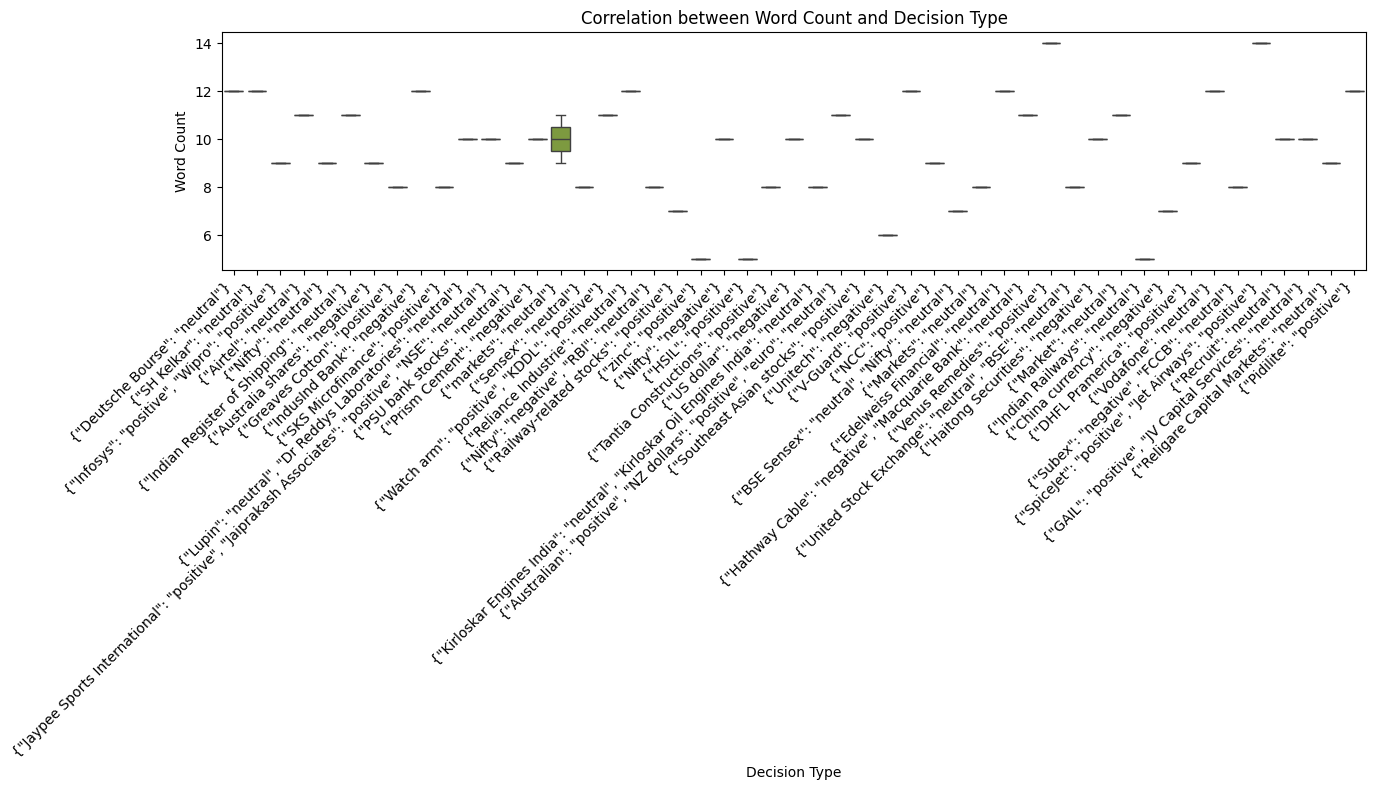

In [14]:
# Box plot of word count by decision type
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_sampled, x='Decisions', y='Words', palette="husl")
plt.title('Correlation between Word Count and Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Word Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()


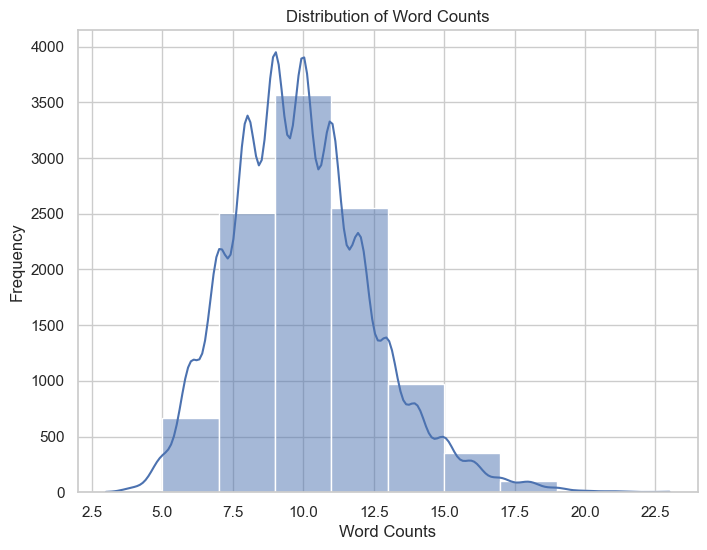

In [15]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Visualize the distribution of word counts
plt.figure(figsize=(8, 6))
sns.histplot(df['Words'], bins=10, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.show()


# **nltk Packages**

In [16]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sudwi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sudwi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sudwi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Data Preprocessing**

In [17]:
# Download NLTK resources
nltk.download('punkt')

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Clean the text data
df['Cleaned_Title'] = df['Title'].apply(clean_text)

# Tokenize the cleaned text
df['Tokenized_Title'] = df['Cleaned_Title'].apply(word_tokenize)

# Encode the target variable
err_handle=coefficient-0.8;
label_encoder = LabelEncoder()
df['Encoded_Decisions'] = label_encoder.fit_transform(df['Decisions'])

# Display the preprocessed data
print(df[['Title', 'Cleaned_Title', 'Tokenized_Title', 'Decisions', 'Encoded_Decisions']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sudwi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                               Title  \
0  SpiceJet to issue 6.4 crore warrants to promoters   
1                  MMTC Q2 net loss at Rs 10.4 crore   
2  Mid-cap funds can deliver more, stay put: Experts   
3             Mid caps now turn into market darlings   
4  Market seeing patience, if not conviction: Pra...   

                                       Cleaned_Title  \
0   spicejet to issue 64 crore warrants to promoters   
1                   mmtc q2 net loss at rs 104 crore   
2     midcap funds can deliver more stay put experts   
3             mid caps now turn into market darlings   
4  market seeing patience if not conviction praka...   

                                     Tokenized_Title  \
0  [spicejet, to, issue, 64, crore, warrants, to,...   
1          [mmtc, q2, net, loss, at, rs, 104, crore]   
2  [midcap, funds, can, deliver, more, stay, put,...   
3     [mid, caps, now, turn, into, market, darlings]   
4  [market, seeing, patience, if, not, convict

In [18]:
print(df['Encoded_Decisions'].unique())


[5126 3280 3502 ...  951 5048  377]


In [19]:
# Extract text and labels
texts = df['Title'].values
decisions = df['Decisions'].apply(lambda x: list(json.loads(x).values())[0]).values

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(decisions)

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Display preprocessed data
print(f"Texts (first 5): {texts[:5]}")
print(f"Labels (first 5): {labels[:5]}")
print(f"Sequences (first 5): {sequences[:5]}")
print(f"Padded sequences (first 5): {data[:5]}")
print(f"Max sequence length: {max_length}")

Texts (first 5): ['SpiceJet to issue 6.4 crore warrants to promoters'
 'MMTC Q2 net loss at Rs 10.4 crore'
 'Mid-cap funds can deliver more, stay put: Experts'
 'Mid caps now turn into market darlings'
 'Market seeing patience, if not conviction: Prakash Diwan']
Labels (first 5): [1 1 2 2 1]
Sequences (first 5): [[634, 1, 157, 74, 65, 7, 2920, 1, 518], [1598, 44, 9, 69, 10, 4, 70, 65, 7], [432, 255, 208, 120, 2089, 138, 322, 926, 378], [432, 662, 301, 695, 246, 26, 4080], [26, 1599, 5431, 663, 79, 3390, 224, 444]]
Padded sequences (first 5): [[ 634    1  157   74   65    7 2920    1  518    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [1598   44    9   69   10    4   70   65    7    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [ 432  255  208  120 2089  138  322  926  378    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [ 432  662  301  695  246   26 4080    0    0    0    0    0    0    0
     

In [20]:

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
    words = word_tokenize(text)  # Tokenizing
    words = [word for word in words if word not in stopwords.words('english')]  # Removing stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

# Apply preprocessing to texts
texts_processed = [preprocess_text(text) for text in texts]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(decisions)

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_processed)
sequences = tokenizer.texts_to_sequences(texts_processed)

# Pad the sequences
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print shapes of the data to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8602, 17)
X_test shape: (2151, 17)
y_train shape: (8602,)
y_test shape: (2151,)


# **RNNs Model**

In [21]:
# Define the RNN model with tuning
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with tuned hyperparameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy*err_handle*100}'"%")

# Save the model
model.save('tuned_rnn_model.keras')


Epoch 1/20


C:\Users\Sudwi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


269/269 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.3280 - loss: -19.1068 - val_accuracy: 0.3068 - val_loss: -196.0216
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.3857 - loss: -409.7410 - val_accuracy: 0.3068 - val_loss: -900.6962
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.3624 - loss: -1591.5797 - val_accuracy: 0.3068 - val_loss: -1905.3322
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.3211 - loss: -3313.2871 - val_accuracy: 0.3068 - val_loss: -3963.5933
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.3181 - loss: -4637.7715 - val_accuracy: 0.3068 - val_loss: -4544.0781
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.3914 - loss: -8092.0068 - val_accuracy: 0.3891 - val_loss: -7009.4585
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.4910 - loss: -11817.2930 - val_accuracy: 0.4305 - val_loss: -9728.9287
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/

# **LTSM Model**

In [22]:
# Define the LSTM model with tuning
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with tuned hyperparameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy*err_handle*100}'"%")

# Save the model
model.save('tuned_lstm_model.keras')


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.3246 - loss: -6.8502 - val_accuracy: 0.3068 - val_loss: -71.5318
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.3327 - loss: -233.9511 - val_accuracy: 0.4035 - val_loss: -676.0968
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.4761 - loss: -1261.3411 - val_accuracy: 0.4035 - val_loss: -1996.9033
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4619 - loss: -3131.1328 - val_accuracy: 0.4142 - val_loss: -4001.2817
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4727 - loss: -5775.7339 - val_accuracy: 0.3575 - val_loss: -6034.9492
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.4422 - loss: -9076.2979 - val_accuracy: 0.4096 - val_loss: -8665.3818
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4753 - loss: -13151.5469 - val_accuracy: 0.4193 - val_loss: -11631.3096
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━

# **CNN Model**

In [23]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with tuned hyperparameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy*coefficient*100}'"%")

# Save the model
model.save('cnn_model.keras')


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3283 - loss: -5847.5986 - val_accuracy: 0.3068 - val_loss: -274933.5938
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3253 - loss: -2336079.7500 - val_accuracy: 0.3068 - val_loss: -15113509.0000
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3286 - loss: -38591088.0000 - val_accuracy: 0.3068 - val_loss: -128466480.0000
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3282 - loss: -216940320.0000 - val_accuracy: 0.3068 - val_loss: -550248576.0000
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3202 - loss: -897378752.0000 - val_accuracy: 0.3068 - val_loss: -1624983168.0000
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3250 - loss: -3032270592.0000 - val_accuracy: 0.3068 - val_loss: -3942367488.0000
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3283 - loss: -5944906240.0000 - val_accuracy: 0.3068 - val_loss: 